# Crypto Explorer – Data Engineering Notebook  
*Autor: Leandro Vidigal (Senior Data Engineer)*  

Este notebook demonstra todo o ciclo de **ingestão → modelagem → análise exploratória** de dados de criptomoedas.  


### Instalação de dependências

In [ ]:
!pip install python-dotenv requests SQLAlchemy psycopg2-binary

### Carregamento seguro de variáveis

In [1]:
import os
from dotenv import load_dotenv
import sqlite3
import pandas as pd
import sqlite3

In [3]:
load_dotenv(r"C:\Users\yanks\Projetos Jupyter\Cadastra\.env")

print("COINCAP_API_KEY =", os.getenv("COINCAP_API_KEY")[:8] + "…")
print("DB_URL          =", os.getenv("DB_URL"))
print("PAGE_SIZE       =", os.getenv("PAGE_SIZE"))

COINCAP_API_KEY = ae35cf33…
DB_URL          = sqlite:///C:/Users/yanks/Projetos Jupyter/Cadastra/crypto.db
PAGE_SIZE       = 2000


### Teste rápido da API

In [5]:
from api_client import CoinCapClient

client = CoinCapClient()
sample = client.fetch_assets(limit=5, offset=0)
print("5 primeiros assets:", [a["id"] for a in sample])

5 primeiros assets: ['bitcoin', 'ethereum', 'tether', 'xrp', 'binance-coin']


###  Criação das tabelas (idempotente)

In [6]:
from db import engine
from models import Base

Base.metadata.create_all(bind=engine)
print("Tabelas criadas com sucesso em:", engine.url)

Tabelas criadas com sucesso em: sqlite:///C:/Users/yanks/Projetos Jupyter/Cadastra/crypto.db


### Ingestão via main.py

In [9]:
from main import main

main()
print("Importação concluída!")

INFO:main:Inserindo histórico de ...
INFO:main:Inserindo histórico de 0chain...
INFO:main:Inserindo histórico de 0x...
INFO:main:Inserindo histórico de 0xbtc...
INFO:main:Inserindo histórico de 0xcert...
INFO:main:Inserindo histórico de 12ships...
INFO:main:Inserindo histórico de 1inch...
INFO:main:Inserindo histórico de 1world...
INFO:main:Inserindo histórico de 2give...
INFO:main:Inserindo histórico de 3x-long-ethereum-token...
INFO:main:Inserindo histórico de 42-coin...
INFO:main:Inserindo histórico de 4new...
INFO:main:Inserindo histórico de 808coin...
INFO:main:Inserindo histórico de 88mph...
INFO:main:Inserindo histórico de 8bit...
INFO:main:Inserindo histórico de 8x8-protocol...
INFO:main:Inserindo histórico de aave...
INFO:main:Inserindo histórico de aavegotchi...
INFO:main:Inserindo histórico de ab-chain-rtb...
INFO:main:Inserindo histórico de abbc-coin...
INFO:main:Inserindo histórico de abulaba...
INFO:main:Inserindo histórico de abyss...
INFO:main:Inserindo histórico de ac3

Importação concluída!


### Análise

In [11]:
conn = sqlite3.connect(r"C:\Users\yanks\Projetos Jupyter\Cadastra\crypto.db")
cursor = conn.cursor()

# Quantos assets foram inseridos?
cursor.execute("SELECT COUNT(*) FROM assets")
print("Total de assets:", cursor.fetchone()[0])

Total de assets: 2342


### Validação e quick EDA

In [15]:
# conecte ao seu banco local
conn = sqlite3.connect(r"C:\Users\yanks\Projetos Jupyter\Cadastra\crypto.db")

# leia toda a tabela 'assets' num DataFrame
df_assets = pd.read_sql_query("SELECT * FROM assets", conn)

# exiba as primeiras linhas como tabela
df_assets.head()

,id,name,symbol,rank,priceUsd,marketCapUsd
0,bitcoin,Bitcoin,BTC,1,104280.834211,2.072282e+12
1,ethereum,Ethereum,ETH,2,2550.023003,3.078501e+11
2,tether,Tether,USDT,3,1.000899,1.532212e+11
3,xrp,XRP,XRP,4,2.174445,1.276095e+11
4,binance-coin,BNB,BNB,5,662.978628,9.547345e+10


### Top-10 por market cap

In [19]:
# Pandas
top10 = df_assets.sort_values("marketCapUsd", ascending=False).head(10)
top10[["id","name","marketCapUsd"]]

,id,name,marketCapUsd
0,bitcoin,Bitcoin,2.072282e+12
1,ethereum,Ethereum,3.078501e+11
2,tether,Tether,1.532212e+11
3,xrp,XRP,1.276095e+11
4,binance-coin,BNB,9.547345e+10
5,solana,Solana,8.276283e+10
6,usd-coin,USDC,6.109603e+10
7,dogecoin,Dogecoin,2.948427e+10
8,tron,TRON,2.557243e+10
9,cardano,Cardano,2.459325e+10


### Série temporal – Bitcoin

<Axes: title={'center': 'Preço do Bitcoin (USD)'}, xlabel='time'>

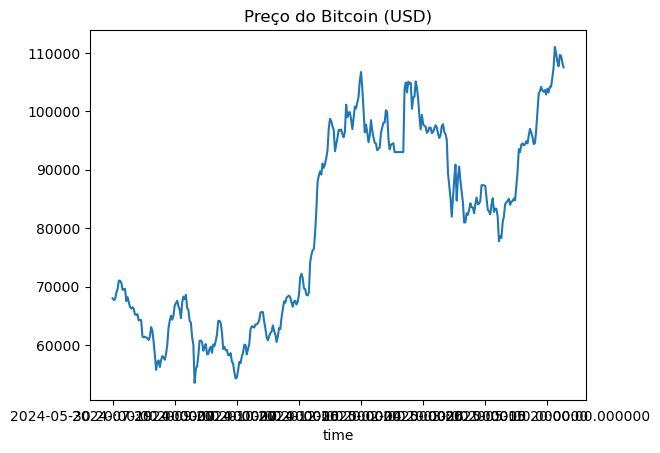

In [23]:
btc = df_history[df_history["asset_id"]=="bitcoin"]
btc.set_index("time")["priceUsd"].plot(title="Preço do Bitcoin (USD)")

### Métricas avançadas

In [26]:
vol = (
    df_history
    .groupby("asset_id")["priceUsd"]
    .agg(volatility=lambda x: x.max() - x.min())
    .reset_index()
    .sort_values("volatility", ascending=False)
)
vol.head(10)

,asset_id,volatility
138,bitcoin-bep2,66683.556944
137,bitcoin,57476.082982
94,aventus,12148.005674
50,ankreth,1495.446880
139,bitcoin-cash,347.769166
128,binance-coin,305.324645
5,aave,301.544576
114,beefy-finance,158.540655
140,bitcoin-cash-abc-2,56.359242
76,arweave,40.032932


In [32]:
zero_vol = (
    df_history
    .groupby("asset_id")["volumeUsd24h"]
    .sum()
    .reset_index()
    .query("volumeUsd24h == 0")
)
zero_vol


,asset_id,volumeUsd24h
0,0chain,0.0
1,0x,0.0
2,0xcert,0.0
3,1inch,0.0
4,88mph,0.0
...,...,...
138,bitcoin-bep2,0.0
139,bitcoin-cash,0.0
140,bitcoin-cash-abc-2,0.0
141,bitcoin-diamond,0.0


<Axes: >

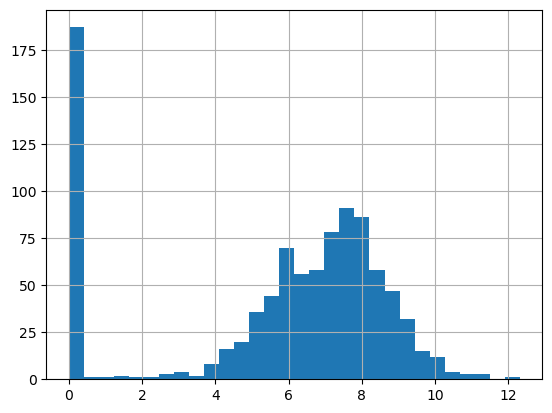

In [38]:
import numpy as np
df_assets["log_mcap"] = np.log10(df_assets["marketCapUsd"] + 1)
df_assets["log_mcap"].hist(bins=30)